In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cross_validation import train_test_split

%matplotlib inline

# Limit rows disp# Limit rows displayed in notebook
pd.set_option('display.max_rows', 20)
pd.set_option('display.precision', 2)

In [2]:
restaurants = pd.read_pickle('restaurant/restaurant_with_topic_dist1.pkl')
restaurants.head()

,business_id,open,review_count,stars,cat.Active Life,cat.Adult Entertainment,cat.Afghan,cat.African,cat.Airports,cat.American (New),...,avg_topic_41,avg_topic_42,avg_topic_43,avg_topic_44,avg_topic_45,avg_topic_46,avg_topic_47,avg_topic_48,avg_topic_49,avg_business_id
0,EmzaQR5hQlF0WIl24NxAZA,1,23,2.5,0,0,0,0,0,1,...,0.0,0,0,0,0,0.0,0,0.0,0.0,EmzaQR5hQlF0WIl24NxAZA
1,KPoTixdjoJxSqRSEApSAGg,1,322,4.0,0,0,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0.0,0.0,KPoTixdjoJxSqRSEApSAGg
2,e5kc0CQ4R-PCCDgb274gSg,1,191,3.5,0,0,0,0,0,0,...,0.0,0,0,0,0,0.1,0,0.1,0.0,e5kc0CQ4R-PCCDgb274gSg
3,45puCRQ6Vh_IIAy7kkfFDQ,1,170,3.5,0,0,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0.0,0.0,45puCRQ6Vh_IIAy7kkfFDQ
4,BESmH-lmMm34_EefL8X9fQ,1,204,4.0,0,0,0,0,0,0,...,0.1,0,0,0,0,0.0,0,0.1,0.1,BESmH-lmMm34_EefL8X9fQ


In [3]:
y = restaurants.stars
y_labels = y.astype(str)
X = restaurants.copy()
del X['stars']
del X['business_id']
del X['avg_business_id']
del X['avg_stars']
X.head()

,open,review_count,cat.Active Life,cat.Adult Entertainment,cat.Afghan,cat.African,cat.Airports,cat.American (New),cat.American (Traditional),cat.Amusement Parks,...,avg_topic_40,avg_topic_41,avg_topic_42,avg_topic_43,avg_topic_44,avg_topic_45,avg_topic_46,avg_topic_47,avg_topic_48,avg_topic_49
0,1,23,0,0,0,0,0,1,0,0,...,0,0.0,0,0,0,0,0.0,0,0.0,0.0
1,1,322,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0.0,0,0.0,0.0
2,1,191,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0.1,0,0.1,0.0
3,1,170,0,0,0,0,0,0,1,0,...,0,0.0,0,0,0,0,0.0,0,0.0,0.0
4,1,204,0,0,0,0,0,0,0,0,...,0,0.1,0,0,0,0,0.0,0,0.1,0.1


In [121]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_validation import cross_val_score
from math import ceil
from sklearn import svm, metrics, tree
from sklearn.metrics import confusion_matrix

def get_rss(lin_model, X_test, y_test):
    predicted = lin_model.predict(X_test)
    print 'Residual sum of squares:'
    print np.mean((predicted - y_test) ** 2)
    return

def get_score(lin_model, X_test, y_test):
    print 'Score:'
    print lin_model.score(X_test, y_test)
    return

def get_cross_val_score(lin_model, X, y):
    scores = cross_val_score(lin_model, X, y, cv=5)
    print "5-fold cross validation scores:"
    print scores
    print
    print "Mean Score: %f" % scores.mean()
    return

def get_coef_matrix(lin_model, X):
    coef_= pd.DataFrame(zip(X.columns.values, lin_model.coef_), columns=['Features', 'Coefficient'])
    return coef_.sort(columns='Coefficient',ascending=False).head(10)

def cust_round(x):
    if x % 1 >= 0.7:
        return round(x)
    elif x % 1 >= 0.5:
        return round(x) - 0.5
    elif x % 1 >= 0.3:
        return round(x) + 0.5
    else:
        return round(x)

def run_and_score(model, X, y,round_method):
    y_labels = y.astype(str)
    
    if model == Ridge:
        mod = model(alpha=.5)
    else:
        mod = model()
    if model == Ridge or model == LinearRegression:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
        mod.fit(X_train, y_train)
        print 'Score as linear regression problem:'
        get_rss(mod, X_test, y_test)
        print
        get_cross_val_score(mod, X, y)
        print '================================================================'
        print
        print 'Score after converting to multiclass problem:'
        predicted_labels = map(lambda x : str(round_method(x)), mod.predict(X_test))
        if round_method == cust_round:
            y_test_labels = map(lambda x: str(x), y_test)
        else:
            y_test_labels = map(lambda x: str(round(x)), y_test)
        categories = np.unique(y_test_labels)
        print metrics.accuracy_score(y_test_labels, predicted_labels)
        print
        print metrics.classification_report(y_test_labels, predicted_labels)
        print
        print pd.DataFrame(confusion_matrix(y_test_labels, predicted_labels),
             index = pd.MultiIndex.from_product([['actual'], categories]),
             columns = pd.MultiIndex.from_product([['predicted'], categories]))
    else:
        categories = np.unique(y_labels.values)
        X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=12)
        mod.fit(X_train, y_train)
        get_cross_val_score(mod, X, y_labels)
        predicted = mod.predict(X_test)
        print
        print metrics.classification_report(y_test, predicted)
        print
        print pd.DataFrame(confusion_matrix(y_test, predicted),
             index = pd.MultiIndex.from_product([['actual'], categories]),
             columns = pd.MultiIndex.from_product([['predicted'], categories]))

# Linear regression

## OLS Regression

#### Run linear regression on the set of features from the business dataset (excluding attributes about reviews)

In [122]:
# features from just the business data set
X_1 = X.loc[:,:'wifi.paid']

run_and_score(LinearRegression, X_1, y, cust_round)

Score as linear regression problem:
Residual sum of squares:
0.259596115461

5-fold cross validation scores:
[ 0.18809425  0.19408245  0.13636728  0.17114252  0.07577891]

Mean Score: 0.153093

Score after converting to multiclass problem:
0.386904761905

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.29      0.25      0.27       117
        3.5       0.35      0.51      0.42       223
        4.0       0.49      0.50      0.49       227
        4.5       0.25      0.07      0.11        54
        5.0       0.00      0.00      0.00         4

avg / total       0.35      0.39      0.36       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   2    1    0   0   0
       2.0         0   0   0   6    5    2   0   0
      

In [123]:
run_and_score(LinearRegression, X_1, y, round)

Score as linear regression problem:
Residual sum of squares:
0.259596115461

5-fold cross validation scores:
[ 0.18809425  0.19408245  0.13636728  0.17114252  0.07577891]

Mean Score: 0.153093

Score after converting to multiclass problem:
0.619047619048

             precision    recall  f1-score   support

        2.0       0.00      0.00      0.00        16
        3.0       0.38      0.59      0.46       148
        4.0       0.74      0.72      0.73       450
        5.0       0.60      0.05      0.10        58

avg / total       0.63      0.62      0.60       672


           predicted              
                 2.0  3.0  4.0 5.0
actual 2.0         0   11    5   0
       3.0         1   87   60   0
       4.0         0  122  326   2
       5.0         0    7   48   3


#### Run linear regression with review attributes added (including topic features)

In [126]:
run_and_score(LinearRegression, X, y, cust_round)

Score as linear regression problem:
Residual sum of squares:
0.259602182393

5-fold cross validation scores:
[ 0.20790232  0.19832582  0.11594976  0.18559797  0.04841539]

Mean Score: 0.151238

Score after converting to multiclass problem:
0.38244047619

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.25      0.03      0.06        31
        3.0       0.28      0.25      0.26       117
        3.5       0.35      0.48      0.40       223
        4.0       0.50      0.49      0.50       227
        4.5       0.28      0.13      0.18        54
        5.0       0.00      0.00      0.00         4

avg / total       0.37      0.38      0.36       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   1    2    0   0   0
       2.0         0   0   0   8    3    2   0   0
       

In [127]:
run_and_score(LinearRegression, X, y, round)

Score as linear regression problem:
Residual sum of squares:
0.259602182393

5-fold cross validation scores:
[ 0.20790232  0.19832582  0.11594976  0.18559797  0.04841539]

Mean Score: 0.151238

Score after converting to multiclass problem:
0.642857142857

             precision    recall  f1-score   support

        2.0       0.00      0.00      0.00        16
        3.0       0.42      0.66      0.51       148
        4.0       0.77      0.73      0.75       450
        5.0       0.62      0.09      0.15        58

avg / total       0.66      0.64      0.63       672


           predicted              
                 2.0  3.0  4.0 5.0
actual 2.0         0   12    4   0
       3.0         0   98   50   0
       4.0         0  118  329   3
       5.0         0    8   45   5


## Regularized Regression

In [128]:
run_and_score(Ridge, X, y, cust_round)

Score as linear regression problem:
Residual sum of squares:
0.256550976018

5-fold cross validation scores:
[ 0.21592737  0.21648273  0.13074362  0.21930364  0.06924676]

Mean Score: 0.170341

Score after converting to multiclass problem:
0.391369047619

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       1.00      0.03      0.06        31
        3.0       0.29      0.26      0.27       117
        3.5       0.35      0.49      0.41       223
        4.0       0.50      0.50      0.50       227
        4.5       0.36      0.15      0.21        54
        5.0       0.00      0.00      0.00         4

avg / total       0.41      0.39      0.37       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   1    2    0   0   0
       2.0         0   0   0   8    3    2   0   0
      

In [130]:
run_and_score(Ridge, X, y, round)

Score as linear regression problem:
Residual sum of squares:
0.256550976018

5-fold cross validation scores:
[ 0.21592737  0.21648273  0.13074362  0.21930364  0.06924676]

Mean Score: 0.170341

Score after converting to multiclass problem:
0.645833333333

             precision    recall  f1-score   support

        2.0       0.00      0.00      0.00        16
        3.0       0.42      0.66      0.51       148
        4.0       0.77      0.74      0.75       450
        5.0       0.80      0.07      0.13        58

avg / total       0.67      0.65      0.63       672


           predicted              
                 2.0  3.0  4.0 5.0
actual 2.0         0   12    4   0
       3.0         0   97   51   0
       4.0         0  116  333   1
       5.0         0    8   46   4


In [131]:
run_and_score(Ridge, X_1, y, cust_round)

Score as linear regression problem:
Residual sum of squares:
0.257815496262

5-fold cross validation scores:
[ 0.19266237  0.20971319  0.14448263  0.20391368  0.089974  ]

Mean Score: 0.168149

Score after converting to multiclass problem:
0.389880952381

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.29      0.24      0.26       117
        3.5       0.35      0.51      0.42       223
        4.0       0.50      0.51      0.50       227
        4.5       0.29      0.07      0.12        54
        5.0       0.00      0.00      0.00         4

avg / total       0.36      0.39      0.36       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   2    1    0   0   0
       2.0         0   0   0   6    5    2   0   0
      

In [132]:
run_and_score(Ridge, X_1, y, round)

Score as linear regression problem:
Residual sum of squares:
0.257815496262

5-fold cross validation scores:
[ 0.19266237  0.20971319  0.14448263  0.20391368  0.089974  ]

Mean Score: 0.168149

Score after converting to multiclass problem:
0.620535714286

             precision    recall  f1-score   support

        2.0       0.00      0.00      0.00        16
        3.0       0.39      0.59      0.47       148
        4.0       0.74      0.72      0.73       450
        5.0       0.50      0.05      0.09        58

avg / total       0.63      0.62      0.60       672


           predicted              
                 2.0  3.0  4.0 5.0
actual 2.0         0   11    5   0
       3.0         0   88   60   0
       4.0         0  121  326   3
       5.0         0    7   48   3


## PCA

In [48]:
from sklearn.decomposition import PCA
from itertools import cycle
from seaborn import plt

def plot_PCA_2D(data, target, target_names):
    colors = cycle('rgbcmykw')
    target_ids = range(len(target_names))
    plt.figure()
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label)
    plt.legend()
    
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

PCA(copy=True, n_components=2, whiten=True)

In [49]:
pca.components_

array([[ -2.00484442e-07,   7.96022308e-05,   2.65772291e-08,
          0.00000000e+00,   2.51772581e-09,   1.51585720e-09,
         -1.85554742e-35,   1.53624113e-07,   6.98111163e-08,
          1.56600415e-09,  -3.34911942e-10,   1.98660989e-09,
         -5.14198226e-09,   2.40715860e-09,   0.00000000e+00,
          0.00000000e+00,  -1.03277492e-08,  -7.30042054e-09,
          0.00000000e+00,   0.00000000e+00,   1.99895628e-09,
         -2.64061459e-08,   1.98521755e-08,   0.00000000e+00,
          7.30390873e-08,   1.64857694e-07,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.82350292e-09,
          0.00000000e+00,   8.42379723e-10,   0.00000000e+00,
         -1.45029651e-09,   7.43749971e-09,   0.00000000e+00,
          5.99998625e-09,  -1.42226698e-08,  -8.24214632e-09,
         -1.67999319e-09,  -4.17212407e-09,   1.83965947e-08,
         -9.87370891e-08,   0.00000000e+00,   1.50319220e-09,
          1.70948555e-08,   0.00000000e+00,   2.08435298e-08,
        

In [50]:
pca.explained_variance_ratio_

array([ 0.95403759,  0.04482022])

In [51]:
pca.explained_variance_ratio_.sum()

0.99885780683388026

In [52]:
X_pca = pca.transform(X)

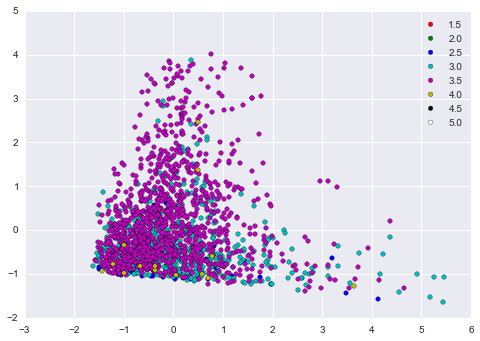

In [53]:
y_target_names = np.unique(y.values)
plot_PCA_2D(X_pca, y.values, y_target_names)

### SVM

In [133]:
run_and_score(svm.SVC, X, y, cust_round)

5-fold cross validation scores:
[ 0.33086053  0.32589286  0.33184524  0.3452381   0.3248503 ]

Mean Score: 0.331737

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.28      0.06      0.10       117
        3.5       0.33      0.47      0.39       223
        4.0       0.36      0.52      0.42       227
        4.5       0.00      0.00      0.00        54
        5.0       0.00      0.00      0.00         4

avg / total       0.28      0.34      0.29       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   0    0    3   0   0
       2.0         0   0   1   1    8    3   0   0
       2.5         0   0   0   3   12   16   0   0
       3.0         0   0   0   7   56   54   0   0
       3.5         0   0   0   7  105  111 

In [134]:
run_and_score(svm.SVC, X, y, round)

5-fold cross validation scores:
[ 0.33086053  0.32589286  0.33184524  0.3452381   0.3248503 ]

Mean Score: 0.331737

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.28      0.06      0.10       117
        3.5       0.33      0.47      0.39       223
        4.0       0.36      0.52      0.42       227
        4.5       0.00      0.00      0.00        54
        5.0       0.00      0.00      0.00         4

avg / total       0.28      0.34      0.29       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   0    0    3   0   0
       2.0         0   0   1   1    8    3   0   0
       2.5         0   0   0   3   12   16   0   0
       3.0         0   0   0   7   56   54   0   0
       3.5         0   0   0   7  105  111 

In [136]:
run_and_score(svm.SVC, X_1, y, cust_round)

5-fold cross validation scores:
[ 0.37537092  0.39136905  0.36458333  0.34375     0.3742515 ]

Mean Score: 0.369865

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.00      0.00      0.00       117
        3.5       0.34      0.69      0.45       223
        4.0       0.46      0.44      0.45       227
        4.5       0.00      0.00      0.00        54
        5.0       0.00      0.00      0.00         4

avg / total       0.27      0.38      0.30       672


           predicted                             
                 1.5 2.0 2.5 3.0  3.5 4.0 4.5 5.0
actual 1.5         0   0   0   0    2   1   0   0
       2.0         0   0   0   0   12   1   0   0
       2.5         0   0   0   0   29   2   0   0
       3.0         0   0   0   0   94  23   0   0
       3.5         0   0   0   0  153  70   0   0

In [137]:
run_and_score(svm.SVC, X_1, y, round)

5-fold cross validation scores:
[ 0.37537092  0.39136905  0.36458333  0.34375     0.3742515 ]

Mean Score: 0.369865

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.00      0.00      0.00       117
        3.5       0.34      0.69      0.45       223
        4.0       0.46      0.44      0.45       227
        4.5       0.00      0.00      0.00        54
        5.0       0.00      0.00      0.00         4

avg / total       0.27      0.38      0.30       672


           predicted                             
                 1.5 2.0 2.5 3.0  3.5 4.0 4.5 5.0
actual 1.5         0   0   0   0    2   1   0   0
       2.0         0   0   0   0   12   1   0   0
       2.5         0   0   0   0   29   2   0   0
       3.0         0   0   0   0   94  23   0   0
       3.5         0   0   0   0  153  70   0   0

In [101]:
run_and_score(svm.SVC, X_pca, y)

NameError: name 'X_pca' is not defined

## Deciscion Trees

In [102]:
run_and_score(tree.DecisionTreeClassifier, X, y)

5-fold cross validation scores:
[ 0.31008902  0.30952381  0.33184524  0.28571429  0.29191617]

Mean Score: 0.305818

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.08      0.10      0.09        31
        3.0       0.25      0.22      0.24       117
        3.5       0.37      0.35      0.36       223
        4.0       0.39      0.43      0.41       227
        4.5       0.10      0.09      0.10        54
        5.0       0.00      0.00      0.00         4

avg / total       0.31      0.31      0.31       672


           predicted                            
                 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
actual 1.5         0   0   0   1   1   1   0   0
       2.0         0   0   2   1   2   5   3   0
       2.5         0   1   3   6  10   9   2   0
       3.0         2   2  11  26  38  33   5   0
       3.5         1   5  15  33  79  77  12   1
      

## Fix some features

In [103]:
# remove features with very low variance ie they have the same value in all samples
from sklearn.feature_selection import VarianceThreshold

X_bools = X.drop(X.columns[1], axis=1)
del X_bools['Price Range_y']
X_bools = X_bools.loc[:, :'wifi.paid']

sel = VarianceThreshold(threshold=(.9*(1-.9)))
reduced = sel.fit_transform(X_bools)
sel.get_support(indices=True)

array([  0,   7,  24, 164, 170, 182, 246, 255, 258, 270, 271, 274, 276,
       277, 278, 279, 288, 290, 300, 301, 302, 306, 308, 310, 311, 312,
       313, 314])

In [104]:
X_reduced_var = X.iloc[:, [  0, 1, 7,  24, 164, 170, 182, 246, 255, 258, 270, 271, 274, 276,
       277, 278, 279, 288, 290, 300, 301, 302, 306, 308, 310, 311, 312,
       313, 314]]
X_reduced = pd.concat([X_reduced_var, X.loc[:, 'avg_review_length':]], axis=1)
X_reduced            

,open,review_count,cat.American (New),cat.Barbeque,cat.Mediterranean,cat.Music Venues,cat.Pita,Accepts Credit Cards_y,Ambience.upscale_y,Corkage_y,...,avg_topic_40,avg_topic_41,avg_topic_42,avg_topic_43,avg_topic_44,avg_topic_45,avg_topic_46,avg_topic_47,avg_topic_48,avg_topic_49
0,1,23,1,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
1,1,322,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
2,1,191,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.1,0,0.1,0.0
3,1,170,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
4,1,204,0,0,0,0,0,1,0,0,...,0,0.1,0,0.0,0,0,0.0,0,0.1,0.1
5,1,73,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
6,1,152,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
7,0,77,1,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
8,0,59,0,0,1,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
9,1,105,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0


In [105]:
run_and_score(Ridge, X_reduced, y)

Score as linear regression problem:
Residual sum of squares:
0.26653411688

5-fold cross validation scores:
[ 0.13929538  0.12165321  0.13689376  0.14541316  0.02530774]

Mean Score: 0.113713

Score after converting to multiclass problem:
0.386904761905

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.32      0.19      0.24       117
        3.5       0.35      0.57      0.43       223
        4.0       0.47      0.47      0.47       227
        4.5       0.44      0.07      0.13        54
        5.0       0.00      0.00      0.00         4

avg / total       0.37      0.39      0.35       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   2    1    0   0   0
       2.0         0   0   0   3    9    1   0   0
       

In [106]:
run_and_score(svm.SVC, X_reduced, y)

5-fold cross validation scores:
[ 0.33086053  0.31547619  0.33482143  0.3422619   0.30838323]

Mean Score: 0.326361

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.20      0.04      0.07       117
        3.5       0.35      0.47      0.40       223
        4.0       0.34      0.52      0.42       227
        4.5       0.00      0.00      0.00        54
        5.0       0.00      0.00      0.00         4

avg / total       0.27      0.34      0.29       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   0    1    2   0   0
       2.0         0   0   0   0    9    4   0   0
       2.5         0   0   0   2    9   20   0   0
       3.0         0   0   0   5   48   64   0   0
       3.5         0   0   0   8  104  109 

In [107]:
X_red1 = X_reduced.drop('review_count', axis=1)


In [108]:
run_and_score(svm.SVC, X_red1, y)

5-fold cross validation scores:
[ 0.35311573  0.35863095  0.3452381   0.36160714  0.35329341]

Mean Score: 0.354377

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.22      0.03      0.06       117
        3.5       0.36      0.47      0.41       223
        4.0       0.37      0.58      0.45       227
        4.5       0.00      0.00      0.00        54
        5.0       0.00      0.00      0.00         4

avg / total       0.28      0.36      0.30       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   0    2    1   0   0
       2.0         0   0   0   0    7    6   0   0
       2.5         0   0   0   1   11   19   0   0
       3.0         0   0   0   4   53   58   2   0
       3.5         0   0   0   5  105  110 

In [109]:
run_and_score(Ridge, X_red1, y)

Score as linear regression problem:
Residual sum of squares:
0.283506510379

5-fold cross validation scores:
[ 0.02019721  0.06803492  0.07008211  0.07666412  0.01131037]

Mean Score: 0.049258

Score after converting to multiclass problem:
0.358630952381

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.28      0.12      0.17       117
        3.5       0.35      0.64      0.45       223
        4.0       0.41      0.37      0.39       227
        4.5       0.00      0.00      0.00        54
        5.0       0.00      0.00      0.00         4

avg / total       0.30      0.36      0.31       672


           predicted                             
                 1.5 2.0 2.5 3.0  3.5 4.0 4.5 5.0
actual 1.5         0   0   0   2    1   0   0   0
       2.0         0   0   0   3    6   4   0   0
       2.5

In [110]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)
X_1_scaled = preprocessing.scale(X_1)

In [111]:
run_and_score(Ridge, X_scaled, y)

Score as linear regression problem:
Residual sum of squares:
0.259607766083

5-fold cross validation scores:
[ 0.20818181  0.19857949  0.11815486  0.18527853  0.04857393]

Mean Score: 0.151754

Score after converting to multiclass problem:
0.383928571429

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.33      0.03      0.06        31
        3.0       0.29      0.26      0.27       117
        3.5       0.35      0.48      0.40       223
        4.0       0.50      0.49      0.50       227
        4.5       0.28      0.13      0.18        54
        5.0       0.00      0.00      0.00         4

avg / total       0.37      0.38      0.37       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   1    2    0   0   0
       2.0         0   0   0   8    3    2   0   0
      

In [113]:
run_and_score(LinearRegression, X_1_scaled, y)

Score as linear regression problem:
Residual sum of squares:
1.18700037014e+27

5-fold cross validation scores:
[ -5.86612809e+27  -4.66898163e+27  -3.44545906e+27  -3.94936473e+27
  -2.37086115e+27]

Mean Score: -4060158933045056312237359104.000000

Score after converting to multiclass problem:
0.39880952381

             precision    recall  f1-score   support

-2.7301882806e+13       0.00      0.00      0.00         0
-3.2326856514e+14       0.00      0.00      0.00         0
-3.89498547231e+14       0.00      0.00      0.00         0
-4.47833966396e+13       0.00      0.00      0.00         0
-6.63258633396e+14       0.00      0.00      0.00         0
-7.17042966824e+13       0.00      0.00      0.00         0
        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
2.86250399471e+13       0.00      0.00      0.00         0
        3.0       0.30      0.25      0.27       117
3.023

ValueError: Shape of passed values is (17, 17), indices imply (8, 8)

In [114]:
run_and_score(svm.SVC, X_scaled, y)

5-fold cross validation scores:
[ 0.40207715  0.4047619   0.39285714  0.38095238  0.3488024 ]

Mean Score: 0.385890

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.32      0.11      0.16       117
        3.5       0.36      0.51      0.42       223
        4.0       0.43      0.59      0.50       227
        4.5       0.00      0.00      0.00        54
        5.0       0.00      0.00      0.00         4

avg / total       0.32      0.39      0.34       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   0    2    1   0   0
       2.0         0   0   0   3    6    4   0   0
       2.5         0   0   0   6   19    6   0   0
       3.0         0   0   0  13   77   27   0   0
       3.5         0   0   0  13  113   97 

In [115]:
run_and_score(svm.SVC, X_1_scaled, y)

5-fold cross validation scores:
[ 0.40801187  0.39434524  0.3764881   0.38541667  0.36676647]

Mean Score: 0.386206

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.43      0.10      0.17       117
        3.5       0.38      0.65      0.48       223
        4.0       0.47      0.54      0.51       227
        4.5       0.33      0.02      0.04        54
        5.0       0.00      0.00      0.00         4

avg / total       0.39      0.42      0.36       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   0    3    0   0   0
       2.0         0   0   0   1    9    3   0   0
       2.5         0   0   0   4   23    4   0   0
       3.0         0   0   0  12   82   23   0   0
       3.5         0   0   0   8  144   71 